In [76]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
#plt.style.use('fivethirtyeight')
import matplotlib
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error,f1_score,classification_report
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.ensemble import RandomForestRegressor
import pmdarima as pm
import pickle

#### Cargamos el dataset

In [21]:
df = pd.read_csv(r"C:\Users\adria\Desktop\Carpeta pruebas Python\Proyecto_ML\data\processed\temp_spain_clear.csv",index_col='dt')

#### El index son fechas, lo convertimos en datetime

In [22]:
df.index = pd.to_datetime(df.index)

#### Partimos del año 1800

In [23]:
df = df.loc['1800':]

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2556 entries, 1800-01-01 to 2012-12-01
Data columns (total 1 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   AverageTemperature  2556 non-null   float64
dtypes: float64(1)
memory usage: 39.9 KB


#### Pintamos grafica 

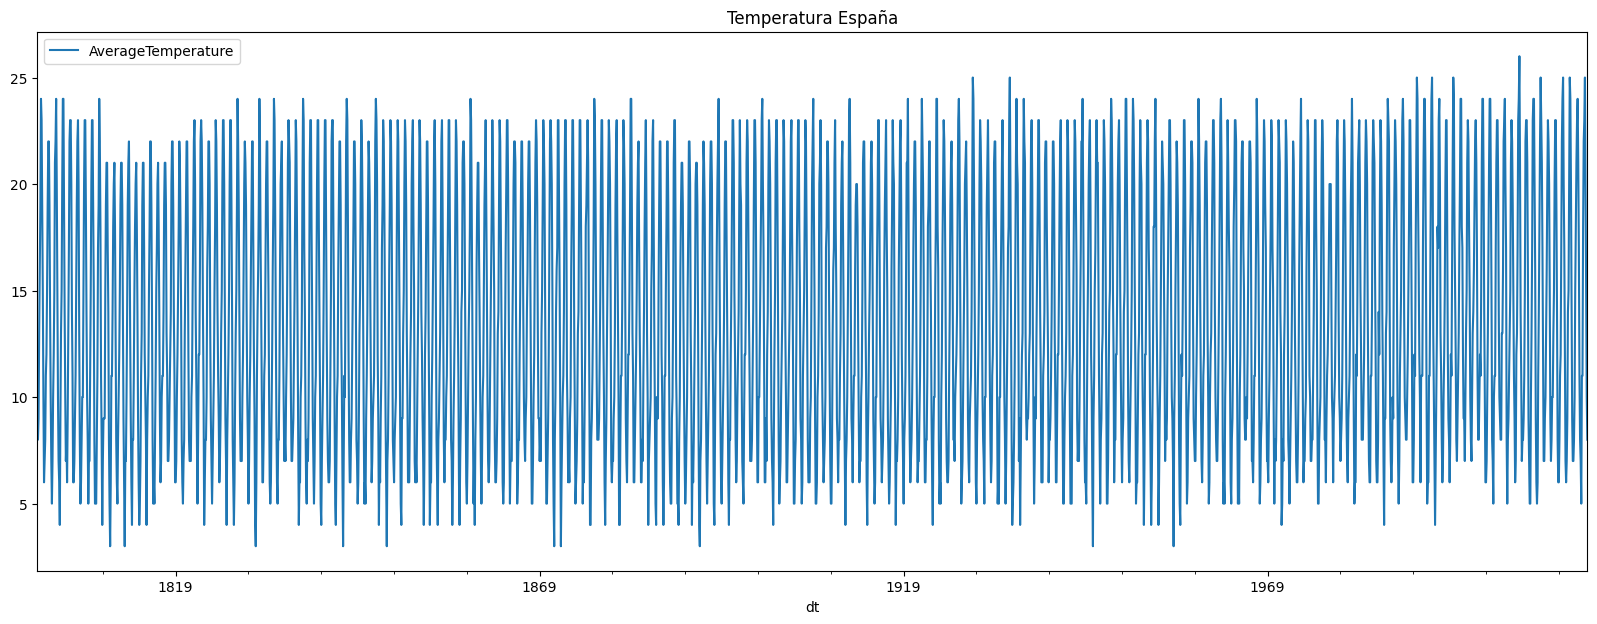

In [25]:

df.plot(figsize=(20,7))
plt.title('Temperatura España')
plt.show()

#### Pintamos temperaturas medias por año

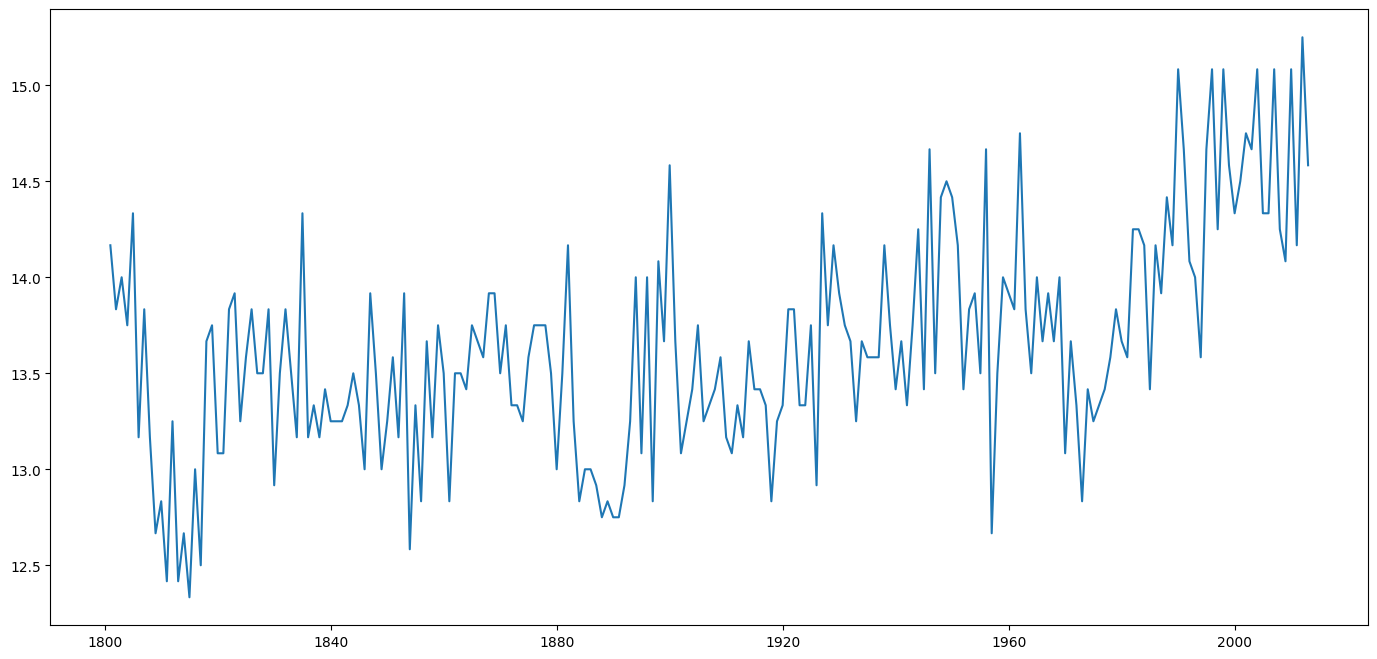

In [26]:
plt.figure(figsize=(17,8))
plt.plot(df.resample('Y').mean());

#### Densidad

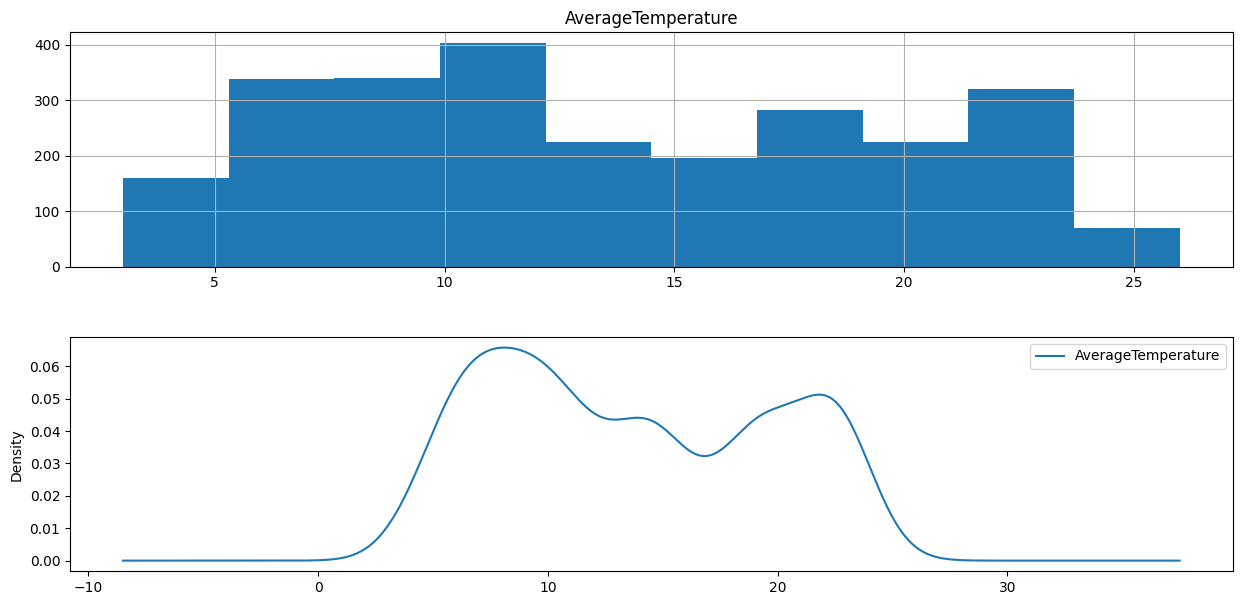

In [27]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=False, sharey=False, figsize=(15,7))
df.hist(ax=ax1)
df.plot(kind='kde',ax=ax2)
plt.show()

#### Descomposicion

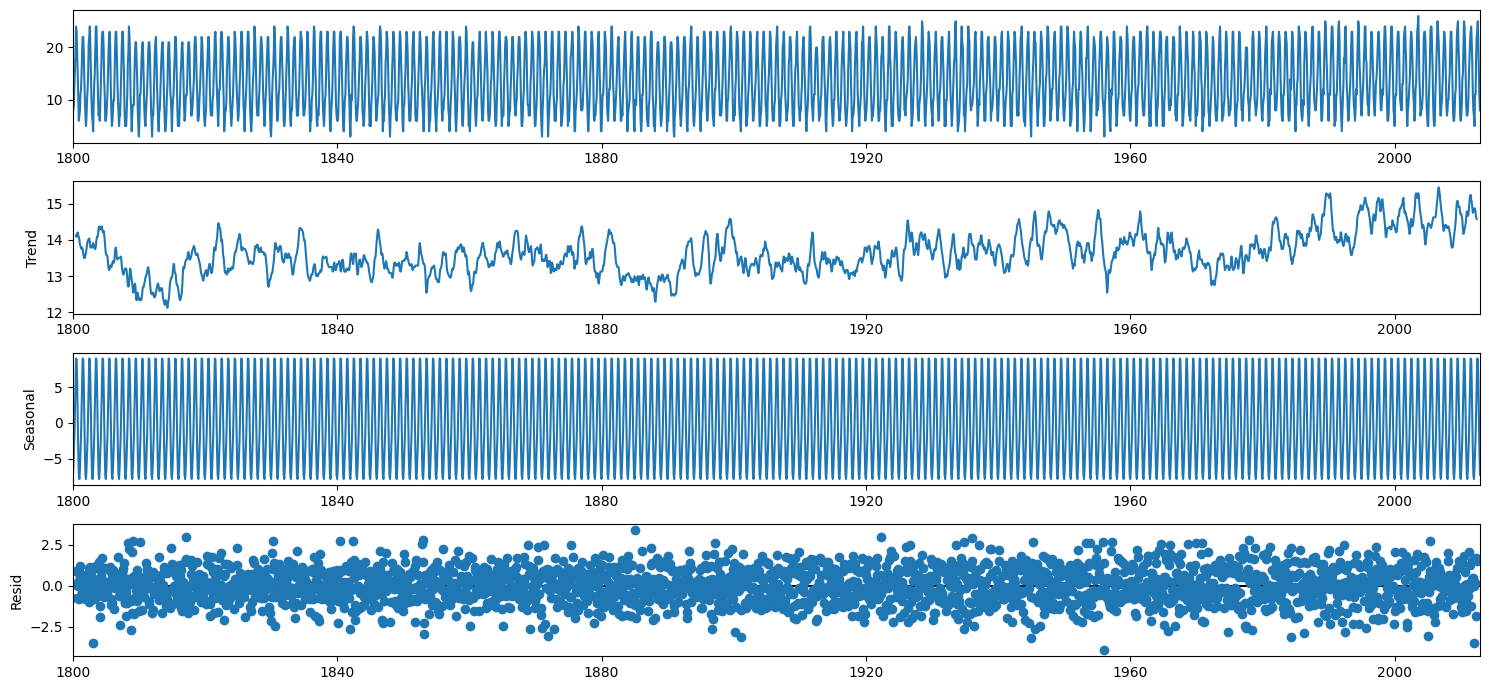

In [28]:
decomposition = seasonal_decompose(df,period=12, model='additive')
plt.rcParams['figure.figsize'] = 15, 7
decomposition.plot()
plt.show()

#### Correlacion y autocorrelacion

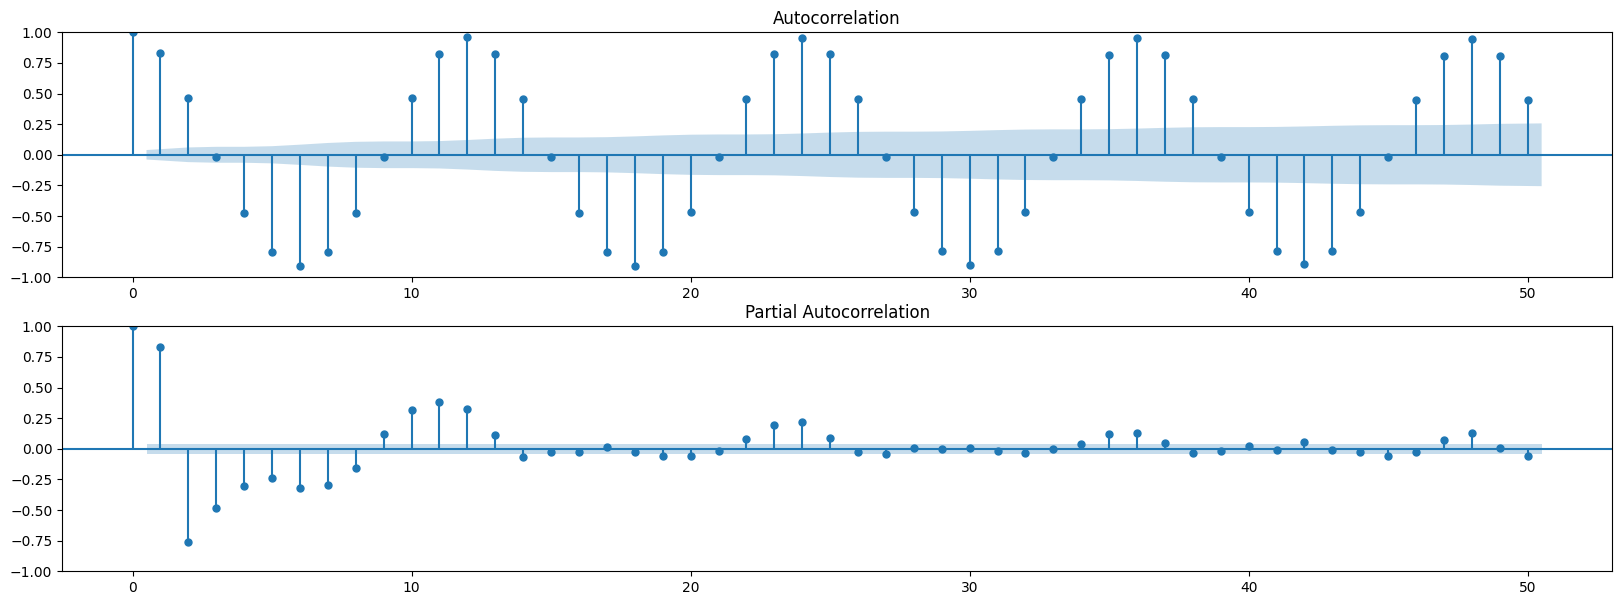

In [29]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(20,7), sharex=False, sharey=False)
ax1 = plot_acf(df, lags=50, ax=ax1)
ax2 = plot_pacf(df, lags=50, ax=ax2)
plt.show()

### Pasarle el test AdFuller

In [30]:
print ('Resultados del test Dickey-Fuller:')
dftest = adfuller(df)

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Resultados del test Dickey-Fuller:
Test Statistic                   -4.311676
p-value                           0.000424
#Lags Used                       26.000000
Number of Observations Used    2529.000000
Critical Value (1%)              -3.432938
Critical Value (5%)              -2.862684
Critical Value (10%)             -2.567379
dtype: float64


In [31]:
"""df_diff = df_esp_1960.diff().diff(12)
df_diff.dropna(inplace=True)
df_diff.tail()"""

'df_diff = df_esp_1960.diff().diff(12)\ndf_diff.dropna(inplace=True)\ndf_diff.tail()'

In [32]:
"""print ('Resultados del test Dickey-Fuller:')
dftest = adfuller(df_diff)

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)"""

"print ('Resultados del test Dickey-Fuller:')\ndftest = adfuller(df_diff)\n\ndfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])\nfor key, value in dftest[4].items():\n    dfoutput['Critical Value (%s)'%key] = value\nprint(dfoutput)"

#### Hacer el autoarima

In [33]:
model = pm.auto_arima(df, d=1, D=1,
                      seasonal=True, m=12, trend='c', 
                      start_p=0, start_q=0, max_order=9, test='kpss', stepwise=True, trace=True, n_jobs=-1)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=3.46 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=10831.371, Time=0.11 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=9632.669, Time=0.67 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=6.15 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=10363.477, Time=0.22 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=9355.650, Time=3.34 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=10.16 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=3.07 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=9835.196, Time=2.87 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=9128.765, Time=4.67 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=9402.753, Time=1.08 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=28.64 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=5.72 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=9026.096, Time=5.59 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=92

In [34]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 2556
Model:             SARIMAX(5, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -4419.022
Date:                            Tue, 21 Mar 2023   AIC                           8856.043
Time:                                    21:20:16   BIC                           8908.613
Sample:                                01-01-1800   HQIC                          8875.112
                                     - 12-01-2012                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0011      0.027      0.038      0.969      -0.053       0.055
ar.L1         -0.6707      0.019    -35.755      0.000      -0.707      -0.634
ar.L2         -0.5358      0.022    -24.433      0.000      -0.579      -0.493
ar.L3         -0.4000      0.023    -17.661      0.000      -0.444      -0.356
ar.L4         -0.3074      0.023    -13.382      0.000      -0.352      -0.262
ar.L5         -0.1514      0.020     -7.540      0.000      -0.191      -0.112
ar.S.L12      -0.6734      0.018    -36.724      0.000      -0.709      -0.637
ar.S.L24      -0.3195      0.019    -17.243      0.000      -0.356      -0.283
sigma2         1.8867      0.051     36.847      0.000       1.786       1.987
===================================================================================
Ljung-Box (L1) (Q):                   1.17   Jarque-Bera (JB):                 2.51
Prob(Q):                              0.28   Prob(JB):                         0.29
Heteroskedasticity (H):               1.36   Skew:                             0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Entrenar el SARIMAX

In [35]:
model = SARIMAX(df,order=(5,1,0),seasonal_order=(2,1,0,12))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                 AverageTemperature   No. Observations:                 2556
Model:             SARIMAX(5, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -4419.022
Date:                            Tue, 21 Mar 2023   AIC                           8854.045
Time:                                    21:20:18   BIC                           8900.774
Sample:                                01-01-1800   HQIC                          8870.995
                                     - 12-01-2012                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6707      0.019    -35.757      0.000      -0.707      -0.634
ar.L2         -0.5358      0.022    -24.435      0.000      -0.579      -0.493
ar.L3         -0.4000      0.023    -17.662      0.000      -0.444      -0.356
ar.L4         -0.3074      0.023    -13.383      0.000      -0.352      -0.262
ar.L5         -0.1514      0.020     -7.540      0.000      -0.191      -0.112
ar.S.L12      -0.6734      0.018    -36.726      0.000      -0.709      -0.637
ar.S.L24      -0.3195      0.019    -17.243      0.000      -0.356      -0.283
sigma2         1.8867      0.051     36.851      0.000       1.786       1.987
===================================================================================
Ljung-Box (L1) (Q):                   1.17   Jarque-Bera (JB):                 2.51
Prob(Q):                              0.28   Prob(JB):                         0.28
Heteroskedasticity (H):               1.36   Skew:                             0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

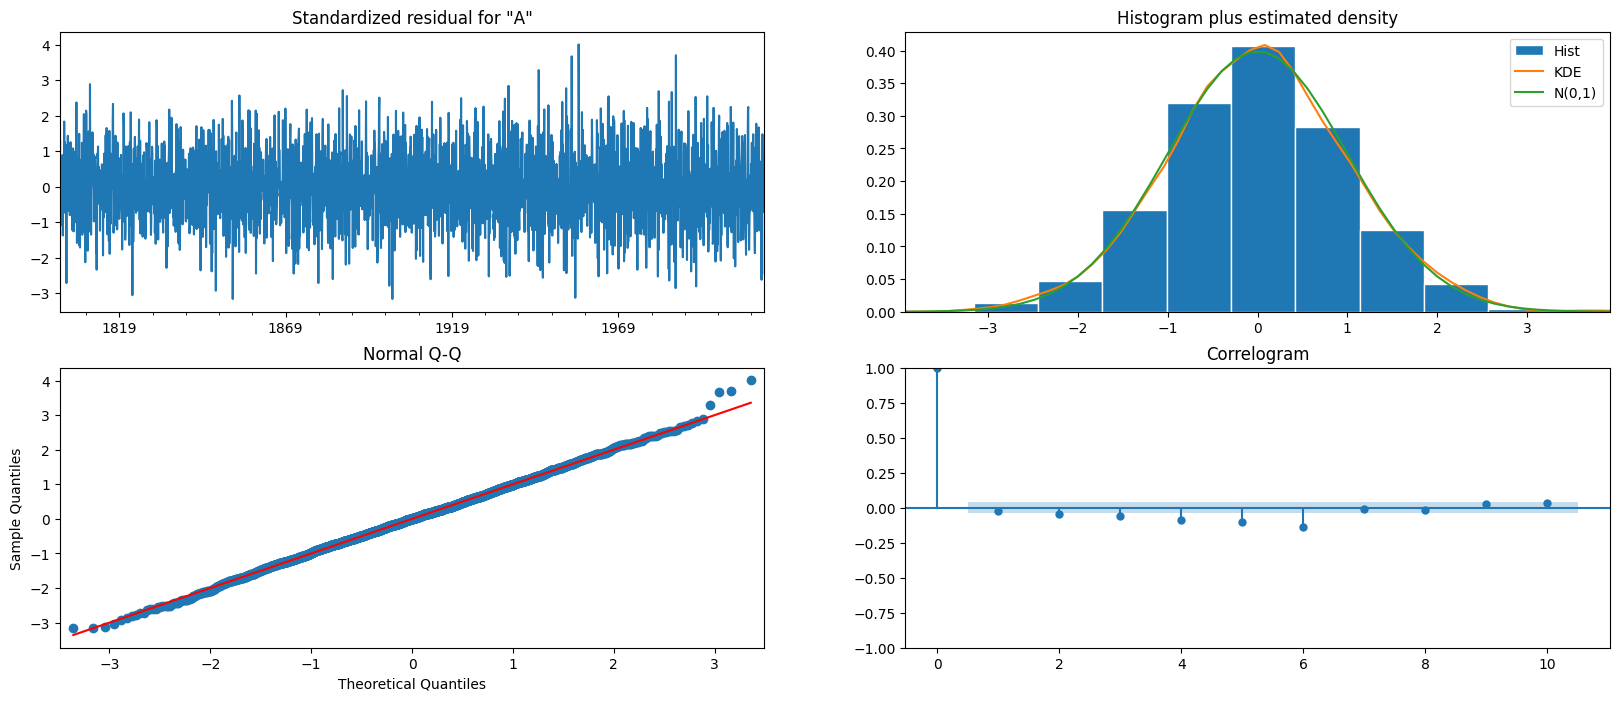

In [36]:
results.plot_diagnostics(figsize=(20, 8))
plt.show()

#### Predicciones

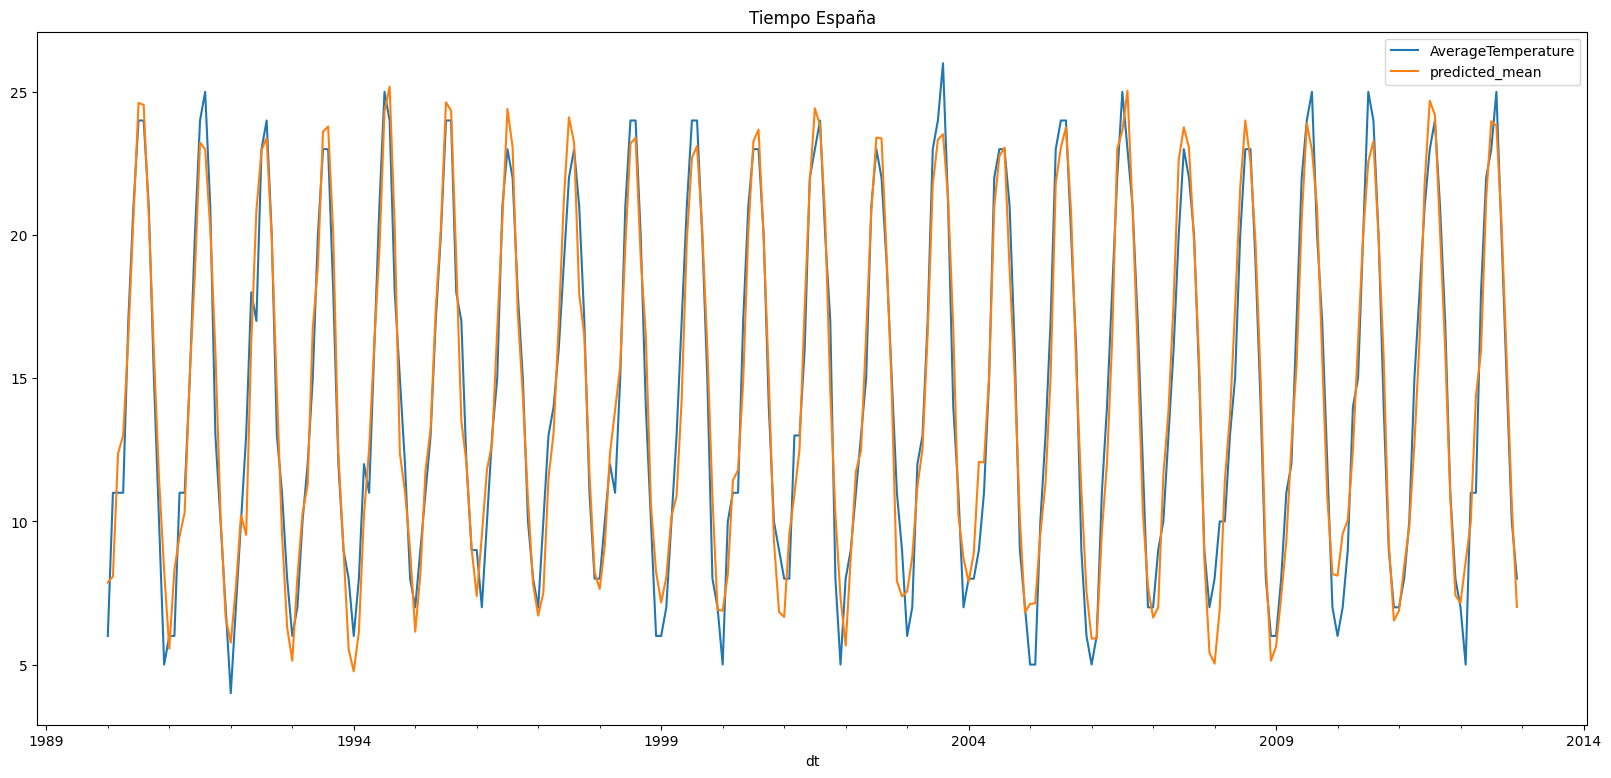

In [42]:
predictions = results.predict(start=0, end=len(df)-1)
title = 'Tiempo España'
ax = df.loc['1990':].plot(legend=True,figsize=(20,9),title=title)
predictions.loc['1990':].plot(legend=True)
ax.autoscale()

#### Predcciones por 20 años

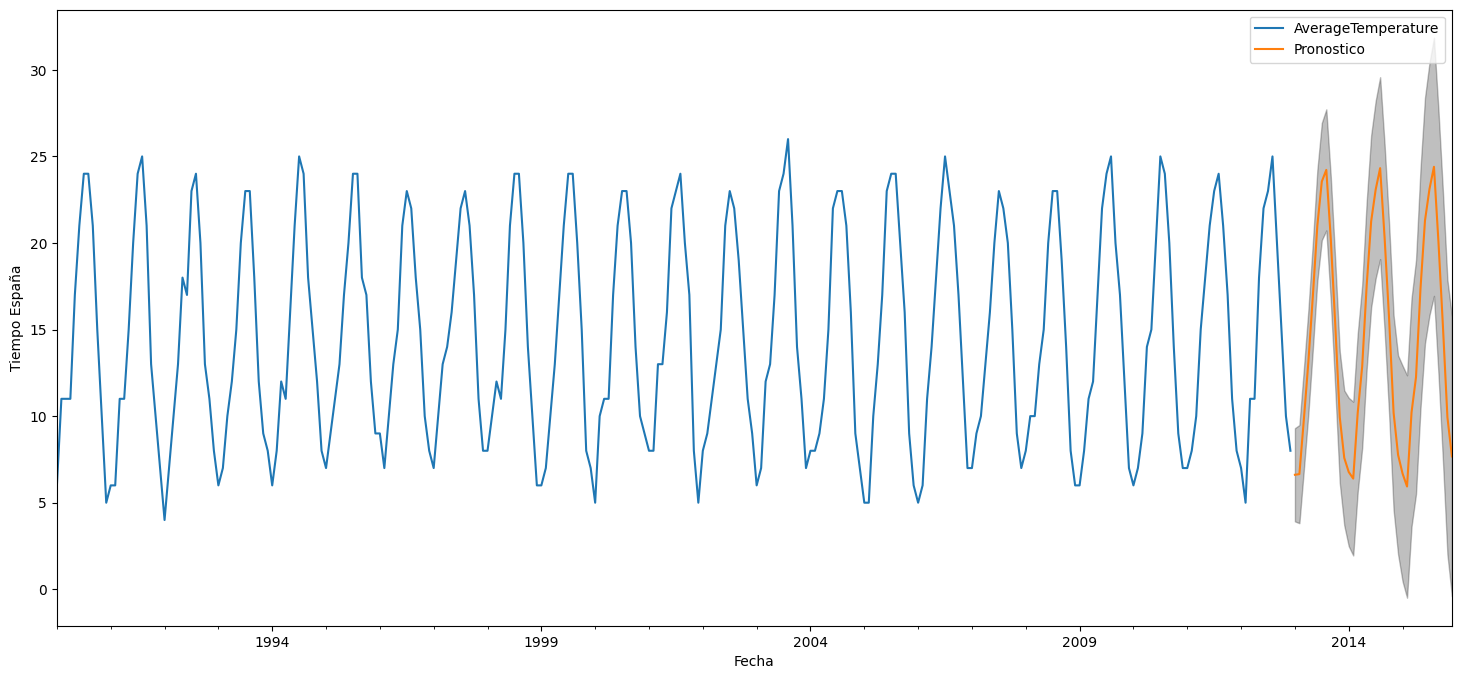

In [41]:
pred_f = results.get_forecast(steps=36)
pred_ci = pred_f.conf_int()
ax = df.loc['1990':].plot(label='Real', figsize=(18, 8))
pred_f.predicted_mean.plot(ax=ax, label='Pronostico')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Fecha')
ax.set_ylabel('Tiempo España')
plt.legend()
plt.show()

In [1]:
print('r2_score: (%s)'%r2_score(df[-36:],pred_f.predicted_mean))
print('MAE: (%s)'%mean_absolute_error(df[-36:],pred_f.predicted_mean))
print('MSE (%s)'%mean_squared_error(df[-36:],pred_f.predicted_mean))
print(mean_squared_log_error(df[-36:],pred_f.predicted_mean))
print(median_absolute_error(df[-36:],pred_f.predicted_mean))

NameError: name 'r2_score' is not defined

#### Guardamos el modelo entrenado

In [39]:
"""with open(r"C:\Users\adria\Desktop\Mi primer proyecto\Proyecto_ML\model\results.pickle", "wb") as f:
    pickle.dump(results, f)"""

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 14-15: truncated \UXXXXXXXX escape (2555853503.py, line 2)

#### Con este comando leemos el archivo guardado anteriormente

In [ ]:
"""with open(r"C:\Users\adria\Desktop\Mi primer proyecto\Proyecto_ML\model\results.pickle", "rb") as f:
    results_pick = pickle.load(f)
print(results_pick)"""